# Preprocessing GFED5

For our analyses, we want to obtain the GFED5 burned_fraction or burned_percentage (per pixel) in an iris cube on a 0.5° by 0.5° grid. Currently, the files (.nc) are stored in one file per year. The individual files are on a 0.25° by 0.25° grid and contain i.a., burned_fraction.

In this script we'll extract the burned_fraction from the GFED5 files (.nc) and merge the individual months and years (2002-2020) into one iris datacube file. We'll regrid this datacube to a 0.5° by 0.5° grid and save the resulting cube.

## 1. Loading packages

In [4]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import rasterio
import iris
from iris.coord_systems import GeogCS
import iris.quickplot as qplt
import cftime
import cf_units

from Global_Variables import OBSERVATIONS_PATH, SUPPLEMENTARY_DATA_PATH

## 2. Load the GFED5 files

Select the location of the individual (yearly) GFED files

In [2]:
GFED_DIRECTORY = os.path.join(OBSERVATIONS_PATH, 'GFED5', '')
GFED_DATA_DIRECTORY = os.path.join(GFED_DIRECTORY, 'Original', '')

## 3. Select the burned area 'group' and merge all the months in a year

In [73]:
cube_names = [GFED_DATA_DIRECTORY+filename for filename in os.listdir(GFED_DATA_DIRECTORY) if filename.endswith('.nc')]
cubes = iris.load(cube_names, constraints=iris.Constraint(name='Total'))
unit = cf_units.Unit('days since 1901-01-01', calendar='360_day')

landsea_mask_location = os.path.join(SUPPLEMENTARY_DATA_PATH, 'landseamask_no-ant.nc')
landsea_mask = iris.load_cube(landsea_mask_location)
landsea_mask.coords('latitude')[0].guess_bounds()
landsea_mask.coords('longitude')[0].guess_bounds()

In [74]:
for cube in cubes:
    time_coord = cube.coords('time')[0]
    time_coord.units = time_coord.units.change_calendar('standard')
    time_coord.convert_units('days since 1901-01-01')

    cube.coords('lat')[0].units = cf_units.Unit('degrees')
    cube.coords('lat')[0].rename('latitude')
    cube.coords('lon')[0].units = cf_units.Unit('degrees')
    cube.coords('lon')[0].rename('longitude')
    cube.coords('latitude')[0].guess_bounds()
    cube.coords('longitude')[0].guess_bounds()
    

The first years (1997-2000) are on a different resolution than the others. We'll handle the two seprately until we can merge them.

In [75]:
cs = iris.coord_systems.GeogCS(6371229)

first_years = cubes[:48].concatenate_cube()
first_years.coords('latitude')[0].coord_system = cs
first_years.coords('longitude')[0].coord_system = cs

remaining_years = cubes[48:].concatenate_cube()
remaining_years.coords('latitude')[0].coord_system = cs
remaining_years.coords('longitude')[0].coord_system = cs

The data is in km^2, we want percentage. So we'll multiply by 10^6 to convert it to m^2, divide by the area of the pixel and multiply again by 100 so we go from fraction to percentage. We take the first and third multiplication together and so we multiply by 10^8.

In [76]:
first_years = iris.analysis.maths.multiply(first_years, 100000000)/iris.analysis.cartography.area_weights(first_years)
remaining_years = iris.analysis.maths.multiply(remaining_years, 100000000)/iris.analysis.cartography.area_weights(remaining_years)

C:\Users\slampe\AppData\Local\anaconda3\envs\DA\Lib\site-packages\iris\analysis\cartography.py:412: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
C:\Users\slampe\AppData\Local\anaconda3\envs\DA\Lib\site-packages\iris\analysis\cartography.py:412: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [77]:
remaining_years.collapsed([coord.name() for coord in remaining_years.coords()], iris.analysis.MAX).data

C:\Users\slampe\AppData\Local\anaconda3\envs\DA\Lib\site-packages\iris\coords.py:2226: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


array(100.33424286)

In [7]:
first_years_regridded = first_years.regrid(landsea_mask, iris.analysis.AreaWeighted(mdtol=0.5))
remaining_years_regridded = remaining_years.regrid(landsea_mask, iris.analysis.AreaWeighted(mdtol=0.5))

In [8]:
gfed5 = iris.cube.CubeList([first_years_regridded, remaining_years_regridded]).concatenate_cube()

In [9]:
gfed5_masked = iris.util.mask_cube(gfed5, np.logical_not(landsea_mask.data.data.squeeze()))
gfed5_masked.units = cf_units.Unit('%')
gfed5_masked.rename('Percentage of Area Burned')

In [10]:
gfed5_masked

Percentage Of Area Burned (%),time,latitude,longitude
Shape,288,360,720
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x


Let's look at the esample of August 2006

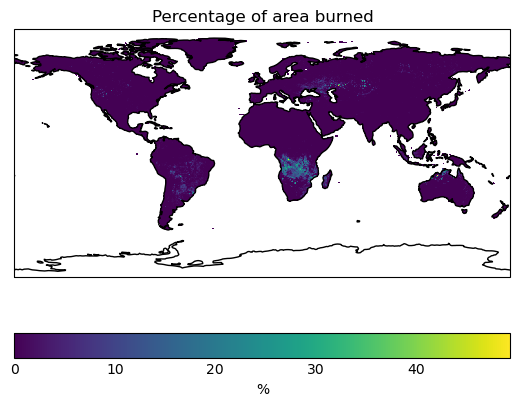

In [11]:
year, month = 2006, 8
qplt.pcolormesh(gfed5_masked.extract(iris.Constraint(time=lambda cell: cell.point == iris.time.PartialDateTime(year=year, month=month, day=1))))
plt.gca().coastlines()
plt.show()

Let's add some final metadata, so our cube's metadata plays nicely with our other observational and model metadata.

In [12]:
cs = iris.coord_systems.GeogCS(6371229)
gfed5_masked.coords('latitude')[0].coord_system = cs
gfed5_masked.coords('longitude')[0].coord_system = cs

In [13]:
iris.save(gfed5_masked, os.path.join(GFED_DIRECTORY, 'GFED5_Burned_Percentage.nc'))